# Original

In [3]:
lista_no_combinaciones = [[1,1]]

In [4]:
import pandas as pd
df_nodes = pd.read_csv("datos_season9.csv")
df_colors = pd.read_csv("resultados_combinaciones_actualizado.csv")

Arreglamos la Columna FIT

In [5]:
df_nodes[df_nodes['fit'].isna()] # los NAs que tenemos se deben a que son complementos (bolsas, bufandas, ...) -
# Vamos a imputarlos como complementos para que no de error

df_nodes['fit'] = df_nodes['fit'].fillna('complementos')

df_nodes['fit'].unique()

array(['tight', 'straight', 'complementos', 'loose', 'oversize'],
      dtype=object)

In [6]:
compatible_fit = {
    "tight": ["straight", "loose", "tight", "complementos"],
    "straight": ["tight", "straight", "loose", "oversize", "complementos"],
    "loose": ["tight", "straight", "loose", "oversize", "complementos"],
    "oversize": ["oversize", "loose", "straight", "complementos"],
    "complementos": ["tight", "straight", "loose", "oversize", "complementos"]
}

def fit_compatible(a, b):
    return b in compatible_fit.get(a, []) or a in compatible_fit.get(b, [])


Arreglamos la columna Weather

In [7]:
df_nodes['weather'].unique()

array(['cold_season', 'warm', 'warm_season', 'cold'], dtype=object)

In [8]:
weather_map = {"cold_season": "cold", "warm_season": "warm", "cold": "cold", "warm": "warm"}

df_nodes['weather'] = df_nodes['weather'].replace(weather_map)
df_nodes['weather'].value_counts()

weather
warm    1129
cold     579
Name: count, dtype: int64

Columna Styles

In [9]:
df_nodes['style'].unique()

array(['street', 'classic', 'casual', 'boho', 'minimal', 'night'],
      dtype=object)

In [10]:
compatible_styles = {
    "street": ["casual", "night", "street"],
    "casual": ["street", "boho", "minimal", "classic", "casual"],
    "classic": ["minimal", "night", "casual", "classic"],
    "minimal": ["classic", "casual", "night", "minimal"],
    "boho": ["casual", "boho"],
    "night": ["classic", "minimal", "street", "night"]
}


def styles_compatible(a, b):
    return b in compatible_styles.get(a, []) or a in compatible_styles.get(b, [])


In [11]:
df_nodes = pd.read_csv("datos_season9.csv")

# Limpiamos el DF
df_nodes['Id_producto'] = df_nodes['id']
df_nodes = df_nodes.drop(columns=['id', 'Unnamed: 0'])

# Insertamos Indice
df_nodes.insert(0, 'indice', range(len(df_nodes)))
df_nodes

# Reordeanar
cols = df_nodes.columns.tolist()
cols.insert(1, cols.pop(cols.index('Id_producto')))
df_nodes = df_nodes[cols]

df_nodes.to_csv('season9_limpios.csv')

In [12]:
import pandas as pd

def generar_grafo():

    df_colors = pd.read_csv("resultados_combinaciones_actualizado.csv")
    df_nodes
    
    # Colores - PREPROCESAMIENTO (Regla de Combinación)
    df_colors['color_a'] = df_colors['color_a'].str.upper()
    df_colors['color_b'] = df_colors['color_b'].str.upper()

    # Solo guardamos las que tienen label == 1 (combinan)
    pares_validos = set()
    for _, row in df_colors[df_colors['label'] == 1].iterrows():
        c1 = row['color_a']
        c2 = row['color_b']
        # Guardamos la tupla ordenada para que el orden (A, B) o (B, A) no importe
        pares_validos.add(tuple(sorted((c1, c2))))

    # Formato Correcto del Hexadecimal (añadir # si falta y mayúsculas)
    df_nodes['hex_normalized'] = df_nodes['hexadecimal'].apply(
        lambda x: '#' + str(x).strip() if not str(x).startswith('#') else str(x).strip()
    ).str.upper()

    # Función para inferir la categoría basada en el título
    # Esto sirve para la regla: "Diferente tipo de prenda"
    def obtener_categoria(title):
        t = str(title).lower()
        if 'jacket' in t: return 'jacket'
        if 'tshirt' in t or 't-shirt' in t: return 'tshirt'
        if 'pant' in t or 'jeans' in t or 'trousers' in t: return 'pant'
        if 'parka' in t: return 'parka'
        if 'shirt' in t: return 'shirt' # Cuidado, puede solaparse con t-shirt si no se ordenan bien los if
        if 'dress' in t: return 'dress'
        if 'skirt' in t: return 'skirt'
        if 'coat' in t: return 'coat'
        if 'blazer' in t: return 'blazer'
        if 'sweater' in t or 'knit' in t or 'cardigan' in t: return 'sweater'
        if 'hoodie' in t or 'sweat' in t: return 'hoodie'
        if 'top' in t: return 'top'
        if 'bag' in t: return 'bag'
        if 'scarf' in t: return 'scarf'
        return 'other'

    df_nodes['categoria_inferida'] = df_nodes['title'].apply(obtener_categoria)

    # ---------------------------------------------------------
    # 4. GENERACIÓN DE ARISTAS (Conexiones)
    # ---------------------------------------------------------
    aristas = []

    # Agrupamos los datos primero por las reglas estrictas de igualdad.
    # Esto optimiza muchísimo el proceso: solo comparamos productos que YA sabemos
    # que tienen la misma Season, Weather y Application.
    grupos = df_nodes.groupby(['season', 'weather', 'application'])

    print("Iniciando generación de aristas...")

    for (season, weather, app), grupo in grupos:
        # Convertimos el grupo a una lista de diccionarios para iterar más rápido
        items = grupo.to_dict('records')
        n_items = len(items)

        # Comparamos todos contra todos dentro del grupo
        for i in range(n_items):
            for j in range(i + 1, n_items):
                u = items[i]
                v = items[j]

                # --- REGLA 1: Diferente tipo de prenda ---
                if u['categoria_inferida'] == v['categoria_inferida']:
                    continue # Saltamos si son lo mismo (ej. camiseta con camiseta)

                # --- REGLA 2: Adventurous (1 vs 4-5 prohibido) ---
                adv_u = u['adventurous']
                adv_v = v['adventurous']
                if (adv_u == 1 and adv_v == 5) or (adv_u == 5 and adv_v == 1) or (adv_u == 1 and adv_v == 4) or (adv_u == 4 and adv_v == 1):
                    continue

                # --- REGLA 3: Colores que combinen ---
                # Buscamos la pareja de colores en nuestro set de combinaciones válidas
                pair_color = tuple(sorted((u['hex_normalized'], v['hex_normalized'])))
                
                if pair_color not in pares_validos:
                    continue # Si no está en la lista de combinaciones, saltamos

                # --- REGLA 4: Combinacion de Niveles --- ?
                pares_niveles = tuple(sorted((u['Nivel'], v['Nivel'])))

                if pares_niveles in lista_no_combinaciones:
                    continue

                # --- REGLA 5: Mismo Weather --- 
                if u['weather'] != v['weather']:
                    continue

                # --- REGLA 6: Diferente Style ---
                style_u = u['style'] 
                style_v = v['style']

                if not styles_compatible(style_u, style_v):
                    continue

                # --- REGLA 7: Compatibilidad de FIT  --
                fit_u = u['fit']
                fit_v = v['fit']

                if not fit_compatible(fit_u, fit_v):
                    continue

                # Si pasa todas las reglas, guardamos la conexión
                aristas.append({
                    'ID_1': u['indice'],
                    'ID_2': v['indice'],
                    'Nombre_1': u['title'],
                    'Nombre_2': v['title'],
                    # 'Weight': 
                })

    # ---------------------------------------------------------
    # 5. GUARDAR RESULTADOS
    # ---------------------------------------------------------
    df_aristas = pd.DataFrame(aristas)
    print(f"Proceso terminado. Se encontraron {len(df_aristas)} conexiones.")
    
    # Guardar a CSV
    df_aristas.to_csv("aristas_grafo.csv", index=False)
    print("Archivo 'aristas_grafo.csv' generado exitosamente.")
    
if __name__ == "__main__":
    generar_grafo()

Iniciando generación de aristas...
Proceso terminado. Se encontraron 73247 conexiones.
Archivo 'aristas_grafo.csv' generado exitosamente.


Miramos a ver si hay nodos aislados


# Intento 2

# Con ponderacion de pesos

In [13]:
import pandas as pd

def generar_grafo():

    df_nodes = pd.read_csv("season9_limpios.csv")
    df_colors = pd.read_csv("resultados_combinaciones_actualizado.csv")

    # Colores - PREPROCESAMIENTO (Regla de Combinación)
    df_colors['color_a'] = df_colors['color_a'].str.upper()
    df_colors['color_b'] = df_colors['color_b'].str.upper()

    # Solo guardamos las que tienen label == 1 (combinan)
    pares_validos = set()
    for _, row in df_colors[df_colors['label'] == 1].iterrows():
        c1 = row['color_a']
        c2 = row['color_b']
        pares_validos.add(tuple(sorted((c1, c2))))

    # Formato Correcto del Hexadecimal (añadir # si falta y mayúsculas)
    df_nodes['hex_normalized'] = df_nodes['hexadecimal'].apply(
        lambda x: '#' + str(x).strip() if not str(x).startswith('#') else str(x).strip()
    ).str.upper()

    # Función para inferir la categoría basada en el título
    def obtener_categoria(title):
        t = str(title).lower()
        if 'jacket' in t: return 'jacket'
        if 'tshirt' in t or 't-shirt' in t: return 'tshirt'
        if 'pant' in t or 'jeans' in t or 'trousers' in t: return 'pant'
        if 'parka' in t: return 'parka'
        if 'shirt' in t: return 'shirt'
        if 'dress' in t: return 'dress'
        if 'skirt' in t: return 'skirt'
        if 'coat' in t: return 'coat'
        if 'blazer' in t: return 'blazer'
        if 'sweater' in t or 'knit' in t or 'cardigan' in t: return 'sweater'
        if 'hoodie' in t or 'sweat' in t: return 'hoodie'
        if 'top' in t: return 'top'
        if 'bag' in t: return 'bag'
        if 'scarf' in t: return 'scarf'
        return 'other'

    df_nodes['categoria_inferida'] = df_nodes['title'].apply(obtener_categoria)

    # ---------------------------------------------------------
    # 4. GENERACIÓN DE ARISTAS (Conexiones)
    # ---------------------------------------------------------
    aristas = []

    # Agrupamos los datos por Season, Weather y Application
    grupos = df_nodes.groupby(['season', 'weather', 'application'])

    print("Iniciando generación de aristas...")

    for (season, weather, app), grupo in grupos:
        items = grupo.to_dict('records')
        n_items = len(items)

        for i in range(n_items):
            for j in range(i + 1, n_items):
                u = items[i]
                v = items[j]

                weight = 0  # Inicializamos weight

                # --- REGLA 1: Diferente tipo de prenda (OBLIGATORIA) ---
                if u['categoria_inferida'] == v['categoria_inferida']:
                    continue

                # --- REGLA 3: Colores que combinen (OBLIGATORIA) ---
                pair_color = tuple(sorted((u['hex_normalized'], v['hex_normalized'])))
                if pair_color not in pares_validos:
                    continue

                # --- REGLA 4: Combinacion de Niveles (OBLIGATORIA) ---
                pares_niveles = tuple(sorted((u['Nivel'], v['Nivel'])))
                if pares_niveles in lista_no_combinaciones:
                    continue

                # --- REGLA 2: Adventurous (Opcional) ---
                adv_u = u['adventurous']
                adv_v = v['adventurous']
                if ((adv_u == 1 and adv_v == 5) or (adv_u == 5 and adv_v == 1)):
                    # continue
                    weight += 0.25

                # --- REGLA 5: Mismo Weather (Opcional) ---
                if u['weather'] == v['weather']:
                    # continue
                    weight += 0.25

                # --- REGLA 6: Diferente Style (Opcional) ---
                style_u = u['style']
                style_v = v['style']
                if styles_compatible(style_u, style_v):
                    # continue
                    weight += 0.25

                # --- REGLA 7: Compatibilidad de FIT (Opcional) ---
                fit_u = u['fit']
                fit_v = v['fit']
                if fit_compatible(fit_u, fit_v):
                    # continue
                    weight += 0.25

                # Guardamos la arista con weight final
                aristas.append({
                    'INDICE_1': u['indice'],
                    'INDICE_2': v['indice'],
                    'Nombre_1': u['title'],
                    'Nombre_2': v['title'],
                    'weight': weight
                })

    # ---------------------------------------------------------
    # 5. GUARDAR RESULTADOS
    # ---------------------------------------------------------
    df_aristas = pd.DataFrame(aristas)
    print(f"Proceso terminado. Se encontraron {len(df_aristas)} conexiones.")
    
    df_aristas.to_csv("aristas_grafo.csv", index=False)
    print("Archivo 'aristas_grafo.csv' generado exitosamente.")

if __name__ == "__main__":
    generar_grafo()


Iniciando generación de aristas...
Proceso terminado. Se encontraron 138693 conexiones.
Archivo 'aristas_grafo.csv' generado exitosamente.


In [14]:
df_aristas = pd.read_csv('aristas_grafo.csv')
df_aristas['weight'].value_counts()

weight
0.75    73277
0.50    54929
0.25    10487
Name: count, dtype: int64

In [15]:
nodos_conectados = set(df_aristas['INDICE_1']).union(set(df_aristas['INDICE_2']))
nodos_totales = set(df_nodes['indice'])
nodos_aislados = nodos_totales - nodos_conectados
print("Número de nodos aislados:", len(nodos_aislados))
nodos_aislados

Número de nodos aislados: 1


{1328}

In [16]:
qq = df_nodes[df_nodes['indice'] == 1328]
qq

,indice,Id_producto,title,family_id,brand,origin,season,color,hexadecimal,top_type,adventurous,weather,print,style,fit,application,Nivel,hex_normalized,categoria_inferida
1328,1328,3632d6b6-8efe-46b4-b97c-46d4b52bb55b,Lykke Pant sharp,1dc55e58-a5c3-462c-b73d-8dd480de90fc,BRAND64,MAINSTREAM,9,black,000000,NaN,2,cold_season,smooth,minimal,straight,special_occasion,1,#000000,pant


# EL DE ENCIMA VA A SER EL BUENO

## Grafo

In [17]:
df_nodes.columns
df_aristas.columns

Index(['INDICE_1', 'INDICE_2', 'Nombre_1', 'Nombre_2', 'weight'], dtype='object')

In [18]:
import networkx as nx
import pandas as pd

# 1. Inicializar el grafo no dirigido
G = nx.Graph()

# 2. Añadir nodos con sus atributos
# Convertimos el dataframe de nodos a un diccionario orientado por el índice ('indice')
# Esto permite cargar todas las columnas (Id_producto, title, brand, etc.) como atributos del nodo.
node_attr = df_nodes.set_index('indice').to_dict('index')
G.add_nodes_from(node_attr.items())

# 3. Añadir aristas desde df_aristas
# 'from_pandas_edgelist' es la forma más rápida de cargar conexiones.
# Al ser un grafo nx.Graph() (no dirigido), si existe la conexión A->B y B->A, 
# se mantendrá una única conexión entre ambos.
G = nx.from_pandas_edgelist(
    df_aristas, 
    source='INDICE_1', 
    target='INDICE_2', 
    edge_attr='weight', 
    create_using=G
)

# --- Verificación ---
print(f"Grafo creado con {G.number_of_nodes()} nodos y {G.number_of_edges()} aristas.")

# Ejemplo para consultar un nodo y ver sus atributos:
# print(G.nodes[df_nodes['indice'].iloc[0]])

Grafo creado con 1707 nodos y 138693 aristas.


Nodos: 1707
Aristas: 138693
Densidad: 0.0953
Grado promedio: 162.50


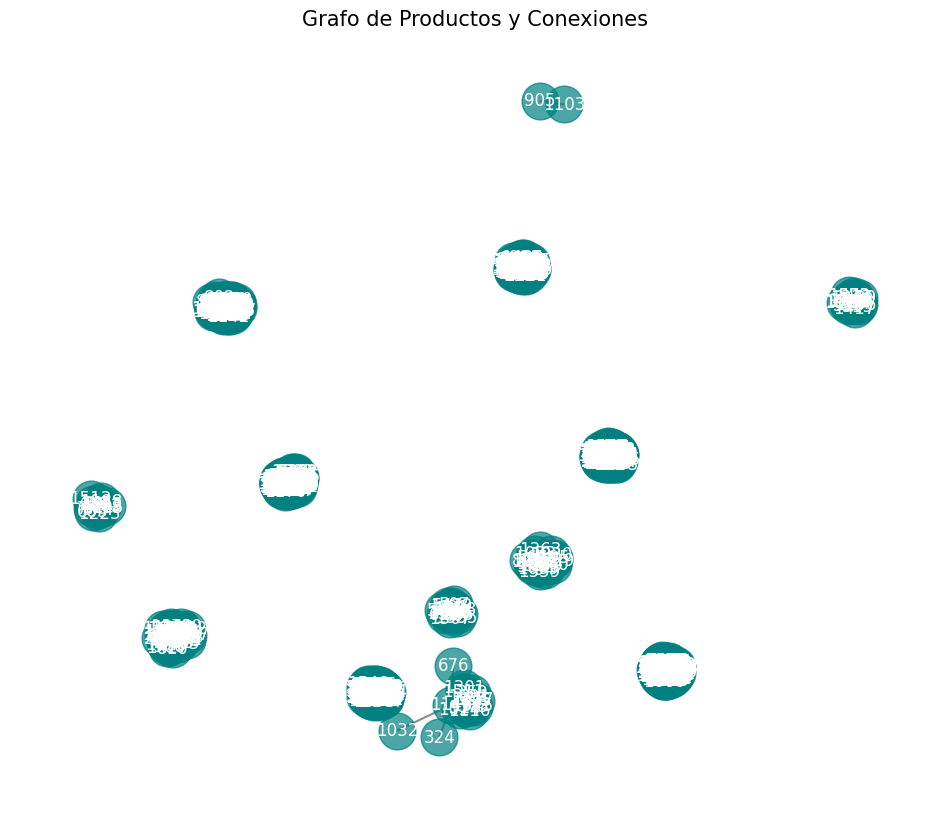

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Crear el grafo (usando el código anterior)
G = nx.Graph()
node_attr = df_nodes.set_index('indice').to_dict('index')
G.add_nodes_from(node_attr.items())
G = nx.from_pandas_edgelist(df_aristas, 'INDICE_1', 'INDICE_2', ['weight'], create_using=G)

# 2. Calcular Características
print(f"Nodos: {G.number_of_nodes()}")
print(f"Aristas: {G.number_of_edges()}")
print(f"Densidad: {nx.density(G):.4f}")
print(f"Grado promedio: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

# 3. Graficar
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5, seed=42) # k ajusta la distancia entre nodos

# Dibujar nodos
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='teal', alpha=0.7)
# Dibujar etiquetas
nx.draw_networkx_labels(G, pos, font_size=12, font_color='white')
# Dibujar aristas (el grosor puede depender del peso)
weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray', alpha=0.9)

plt.title("Grafo de Productos y Conexiones", fontsize=15)
plt.axis('off')
plt.show()

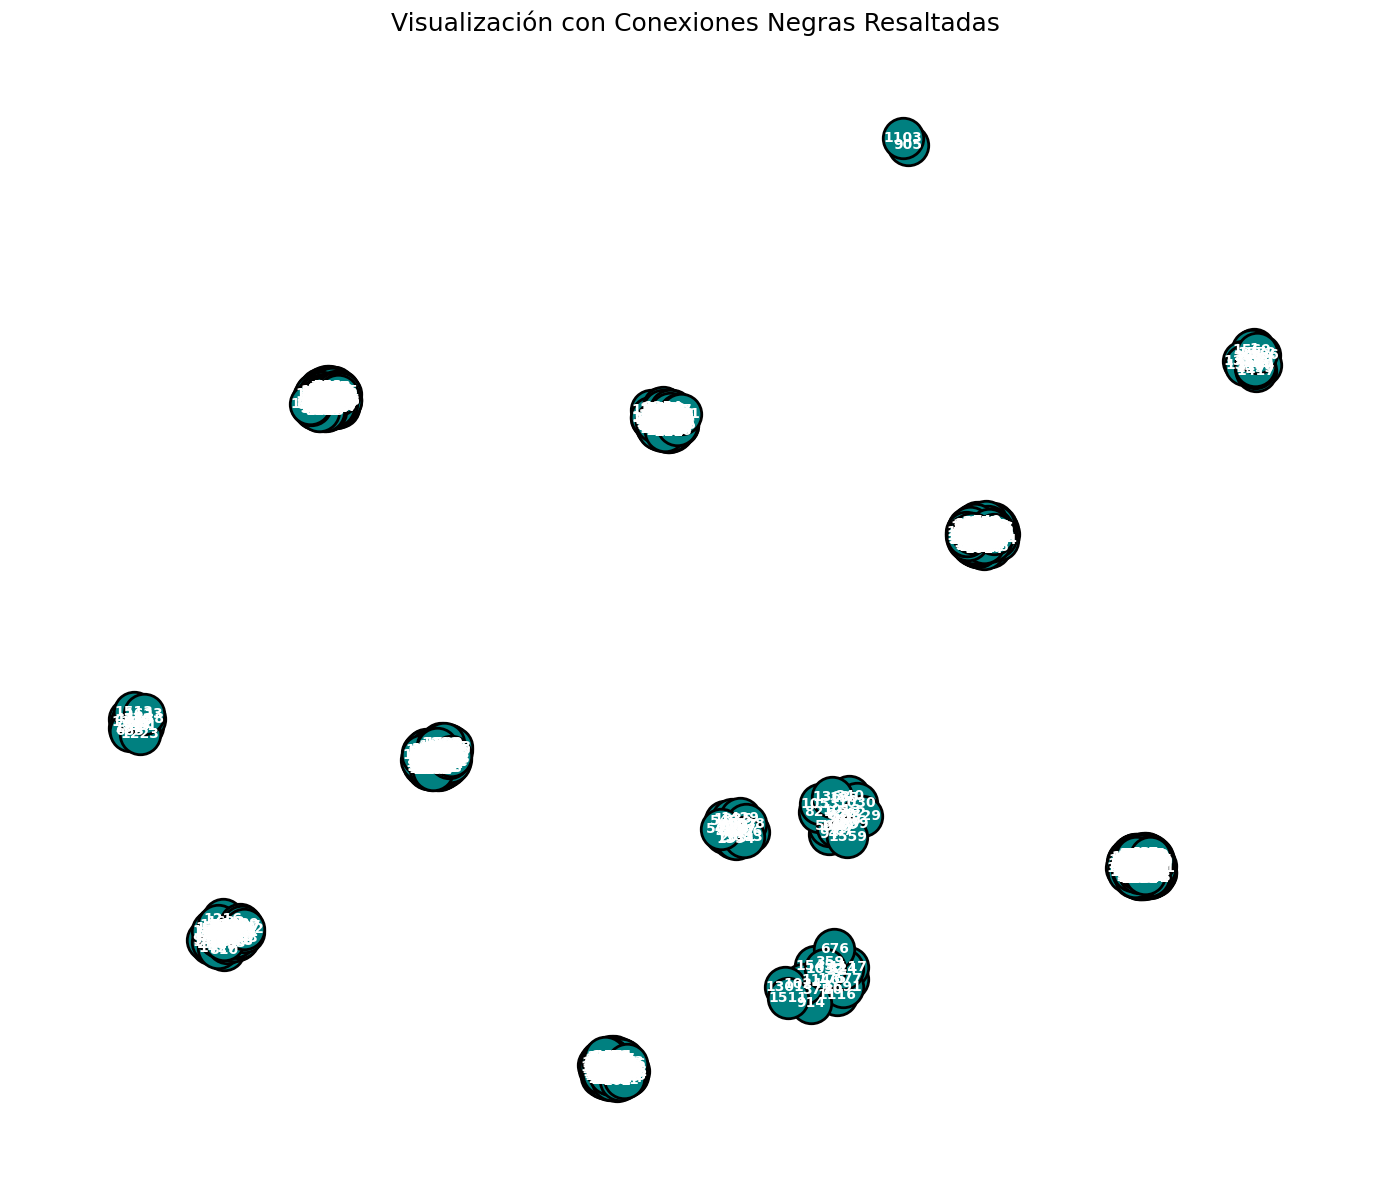

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
# Asumo que pandas ya está importado y tus dataframes df_nodes y df_aristas existen

# 1. Crear el grafo (Igual que antes)
G = nx.Graph()
# Asegúrate de que df_nodes tenga la columna que usas como índice
node_list = df_nodes['indice'].tolist()
G.add_nodes_from(node_list)
G = nx.from_pandas_edgelist(df_aristas, 'INDICE_1', 'INDICE_2', create_using=G)

# 2. Configuración del Lienzo y Layout
plt.figure(figsize=(14, 12), facecolor='white')

# Usamos un k alto para separar bien los grupos
pos = nx.spring_layout(G, k=2.5, iterations=100, seed=42)

# --- CAMBIO CLAVE AQUÍ: ARISTAS NEGRAS Y VISIBLES ---
# 3. Dibujar Aristas
nx.draw_networkx_edges(
    G, pos,
    width=2.5,           # Grosor aumentado para que se vean bien
    edge_color='black',  # Color negro sólido
    alpha=1.0            # Opacidad máxima (sin transparencia)
)
# ----------------------------------------------------

# 4. Dibujar Nodos
# Ponemos un borde negro a los nodos para que combinen con las aristas
nx.draw_networkx_nodes(
    G, pos,
    node_size=850,
    node_color='teal',   # Mantengo el color teal que usabas
    alpha=1.0,
    edgecolors='black',  # Borde negro grueso alrededor del nodo
    linewidths=2.0
)

# 5. Dibujar Etiquetas
nx.draw_networkx_labels(
    G, pos,
    font_size=10,
    font_color='white',
    font_weight='bold'
)

plt.title("Visualización con Conexiones Negras Resaltadas", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()

Sin pesos

In [17]:
import pandas as pd

def generar_grafo():

    df_nodes = pd.read_csv("season9_limpios.csv")
    df_colors = pd.read_csv("resultados_combinaciones_actualizado.csv")

    # Colores - PREPROCESAMIENTO (Regla de Combinación)
    df_colors['color_a'] = df_colors['color_a'].str.upper()
    df_colors['color_b'] = df_colors['color_b'].str.upper()

    # Solo guardamos las que tienen label == 1 (combinan)
    pares_validos = set()
    for _, row in df_colors[df_colors['label'] == 1].iterrows():
        c1 = row['color_a']
        c2 = row['color_b']
        pares_validos.add(tuple(sorted((c1, c2))))

    # Formato Correcto del Hexadecimal (añadir # si falta y mayúsculas)
    df_nodes['hex_normalized'] = df_nodes['hexadecimal'].apply(
        lambda x: '#' + str(x).strip() if not str(x).startswith('#') else str(x).strip()
    ).str.upper()

    # Función para inferir la categoría basada en el título
    def obtener_categoria(title):
        t = str(title).lower()
        if 'jacket' in t: return 'jacket'
        if 'tshirt' in t or 't-shirt' in t: return 'tshirt'
        if 'pant' in t or 'jeans' in t or 'trousers' in t: return 'pant'
        if 'parka' in t: return 'parka'
        if 'shirt' in t: return 'shirt'
        if 'dress' in t: return 'dress'
        if 'skirt' in t: return 'skirt'
        if 'coat' in t: return 'coat'
        if 'blazer' in t: return 'blazer'
        if 'sweater' in t or 'knit' in t or 'cardigan' in t: return 'sweater'
        if 'hoodie' in t or 'sweat' in t: return 'hoodie'
        if 'top' in t: return 'top'
        if 'bag' in t: return 'bag'
        if 'scarf' in t: return 'scarf'
        return 'other'

    df_nodes['categoria_inferida'] = df_nodes['title'].apply(obtener_categoria)

    # ---------------------------------------------------------
    # 4. GENERACIÓN DE ARISTAS (Conexiones)
    # ---------------------------------------------------------
    aristas = []

    # Agrupamos los datos por Season, Weather y Application
    grupos = df_nodes.groupby(['season', 'weather', 'application'])

    print("Iniciando generación de aristas...")

    for (season, weather, app), grupo in grupos:
        items = grupo.to_dict('records')
        n_items = len(items)

        for i in range(n_items):
            for j in range(i + 1, n_items):
                u = items[i]
                v = items[j]


                # --- REGLA 1: Diferente tipo de prenda (OBLIGATORIA) ---
                if u['categoria_inferida'] == v['categoria_inferida']:
                    continue

                # --- REGLA 3: Colores que combinen (OBLIGATORIA) ---
                pair_color = tuple(sorted((u['hex_normalized'], v['hex_normalized'])))
                if pair_color not in pares_validos:
                    continue

                # --- REGLA 4: Combinacion de Niveles (OBLIGATORIA) ---
                pares_niveles = tuple(sorted((u['Nivel'], v['Nivel'])))
                if pares_niveles in lista_no_combinaciones:
                    continue

                # --- REGLA 2: Adventurous (Opcional) ---
                adv_u = u['adventurous']
                adv_v = v['adventurous']
                if ((adv_u == 1 and adv_v == 5) or (adv_u == 5 and adv_v == 1)):
                   continue

                # --- REGLA 5: Mismo Weather (Opcional) ---
                if u['weather'] != v['weather']:
                    continue

                # --- REGLA 6: Diferente Style (Opcional) ---
                style_u = u['style']
                style_v = v['style']
                if not styles_compatible(style_u, style_v):
                    continue

                # --- REGLA 7: Compatibilidad de FIT (Opcional) ---
                fit_u = u['fit']
                fit_v = v['fit']
                if not fit_compatible(fit_u, fit_v):
                    continue

                # Guardamos la arista con weight final
                aristas.append({
                    'ID_1': u['indice'],
                    'ID_2': v['indice'],
                    'Nombre_1': u['title'],
                    'Nombre_2': v['title'],
                    'weight': 1
                })

    # ---------------------------------------------------------
    # 5. GUARDAR RESULTADOS
    # ---------------------------------------------------------
    df_aristas = pd.DataFrame(aristas)
    print(f"Proceso terminado. Se encontraron {len(df_aristas)} conexiones.")
    
    df_aristas.to_csv("aristas_grafo.csv", index=False)
    print("Archivo 'aristas_grafo.csv' generado exitosamente.")

if __name__ == "__main__":
    generar_grafo()

Iniciando generación de aristas...
Proceso terminado. Se encontraron 73277 conexiones.
Archivo 'aristas_grafo.csv' generado exitosamente.


In [18]:
df_aristas = pd.read_csv('aristas_grafo.csv')

In [19]:
nodos_conectados = set(df_aristas['ID_1']).union(set(df_aristas['ID_2']))
nodos_totales = set(df_nodes['indice'])
nodos_aislados = nodos_totales - nodos_conectados
print("Número de nodos aislados:", len(nodos_aislados))
nodos_aislados

Número de nodos aislados: 129


{5,
 15,
 36,
 85,
 142,
 159,
 195,
 231,
 247,
 267,
 366,
 380,
 411,
 492,
 564,
 636,
 789,
 796,
 797,
 799,
 802,
 804,
 806,
 807,
 808,
 809,
 821,
 836,
 838,
 840,
 842,
 889,
 892,
 911,
 929,
 971,
 976,
 977,
 979,
 990,
 1047,
 1053,
 1088,
 1109,
 1124,
 1127,
 1135,
 1163,
 1178,
 1180,
 1185,
 1198,
 1210,
 1238,
 1239,
 1240,
 1241,
 1252,
 1273,
 1274,
 1283,
 1284,
 1300,
 1305,
 1306,
 1307,
 1308,
 1328,
 1375,
 1381,
 1391,
 1398,
 1430,
 1448,
 1481,
 1482,
 1483,
 1485,
 1489,
 1491,
 1492,
 1495,
 1497,
 1498,
 1539,
 1548,
 1550,
 1561,
 1562,
 1563,
 1564,
 1577,
 1580,
 1593,
 1598,
 1604,
 1624,
 1627,
 1631,
 1632,
 1633,
 1634,
 1637,
 1639,
 1640,
 1650,
 1651,
 1652,
 1653,
 1655,
 1660,
 1661,
 1665,
 1667,
 1679,
 1680,
 1686,
 1687,
 1689,
 1690,
 1694,
 1695,
 1696,
 1697,
 1701,
 1704,
 1705,
 1706,
 1707}

In [20]:
aislado = df_nodes[df_nodes['Id_producto'] == '3632d6b6-8efe-46b4-b97c-46d4b52bb55b']
aislado

,indice,Id_producto,title,family_id,brand,origin,season,color,hexadecimal,top_type,adventurous,weather,print,style,fit,application,Nivel,hex_normalized,categoria_inferida
1328,1328,3632d6b6-8efe-46b4-b97c-46d4b52bb55b,Lykke Pant sharp,1dc55e58-a5c3-462c-b73d-8dd480de90fc,BRAND64,MAINSTREAM,9,black,000000,NaN,2,cold_season,smooth,minimal,straight,special_occasion,1,#000000,pant


# HAY QUE BORRARLA

In [21]:
import pandas as pd
import networkx as nx

def construir_y_mostrar_grafo():
    # 1. Cargar los datos
    try:
        df_nodes = pd.read_csv("datos_season9.csv")
        df_edges = pd.read_csv("aristas_grafo.csv")
    except FileNotFoundError as e:
        print(f"Error: No se encuentra el archivo {e.filename}. Asegúrate de haber ejecutado el script de generación primero.")
        return

    # 2. Crear el grafo no dirigido
    G = nx.Graph()

    # 3. Añadir Nodos
    # Añadimos atributos extra al nodo (como el título) para que el print sea más legible
    print("Añadiendo nodos...")
    for _, row in df_nodes.iterrows():
        # Asumimos que la columna clave es 'id'. Si se llama diferente, cámbialo aquí.
        node_id = row['id']
        node_title = row['title']
        # Añadimos el nodo con el atributo 'title'
        G.add_node(node_id, title=node_title)

    # 4. Añadir Aristas (Conexiones)
    print("Añadiendo aristas...")
    for _, row in df_edges.iterrows():
        origen = row['ID_1']
        destino = row['ID_2']
        peso = row['weight'] # Opcional, si quieres guardar el peso
        
        # Añadimos la arista
        G.add_edge(origen, destino, weight=peso)

    # ---------------------------------------------------------
    # 5. PRINT DEL GRAFO Y CONEXIONES
    # ---------------------------------------------------------
    print("\n" + "="*40)
    print("RESUMEN DEL GRAFO")
    print("="*40)
    
    # Información general
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    print(f"Total de Nodos (Prendas): {num_nodes}")
    print(f"Total de Aristas (Combinaciones): {num_edges}")
    
    # Calcular densidad del grafo (opcional, útil para ver qué tan conectado está)
    density = nx.density(G)
    print(f"Densidad del grafo: {density:.4f}")

    print("\n" + "="*40)
    print("DETALLE DE CONEXIONES (Muestra de los primeros 5 nodos conectados)")
    print("="*40)

    # Iteramos sobre los nodos para mostrar sus conexiones
    # Usamos un contador para no imprimir miles de líneas si el CSV es gigante
    contador = 0
    limit = 5 

    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        
        # Solo mostramos nodos que tengan al menos una conexión
        if len(neighbors) > 0:
            node_title = G.nodes[node].get('title', 'Sin Título')
            
            print(f"\nNODE ID: {node} | PRENDA: {node_title}")
            print(f"  --> Conecta con {len(neighbors)} prendas:")
            
            for neighbor in neighbors:
                neighbor_title = G.nodes[neighbor].get('title', 'Sin Título')
                # Obtenemos datos de la arista si existen
                weight = G[node][neighbor].get('weight', 1)
                print(f"      - ID: {neighbor} ({neighbor_title}) [Weight: {weight}]")
            
            contador += 1
            if contador >= limit:
                print(f"\n... (Se han ocultado el resto de nodos para no saturar la consola) ...")
                break

    return G

if __name__ == "__main__":
    grafo = construir_y_mostrar_grafo()

Añadiendo nodos...
Añadiendo aristas...

RESUMEN DEL GRAFO
Total de Nodos (Prendas): 2548
Total de Aristas (Combinaciones): 73277
Densidad del grafo: 0.0226

DETALLE DE CONEXIONES (Muestra de los primeros 5 nodos conectados)

NODE ID: 31 | PRENDA: Sin Título
  --> Conecta con 16 prendas:
      - ID: 402 (Sin Título) [Weight: 1]
      - ID: 438 (Sin Título) [Weight: 1]
      - ID: 494 (Sin Título) [Weight: 1]
      - ID: 733 (Sin Título) [Weight: 1]
      - ID: 757 (Sin Título) [Weight: 1]
      - ID: 810 (Sin Título) [Weight: 1]
      - ID: 966 (Sin Título) [Weight: 1]
      - ID: 1423 (Sin Título) [Weight: 1]
      - ID: 1424 (Sin Título) [Weight: 1]
      - ID: 1425 (Sin Título) [Weight: 1]
      - ID: 1426 (Sin Título) [Weight: 1]
      - ID: 1427 (Sin Título) [Weight: 1]
      - ID: 1428 (Sin Título) [Weight: 1]
      - ID: 1472 (Sin Título) [Weight: 1]
      - ID: 1543 (Sin Título) [Weight: 1]
      - ID: 1549 (Sin Título) [Weight: 1]

NODE ID: 402 | PRENDA: Sin Título
  --> Conec

In [22]:
from pyvis.network import Network
import pandas as pd

def visualizar_interactivo(G):
    # Creamos la red interactiva
    net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")
    
    # Cargamos el grafo de networkx
    net.from_nx(G)
    
    # Personalización: Usar los colores reales y nombres en el hover
    for node in net.nodes:
        # Recuperamos el título y el hex de los atributos que guardamos
        node_id = node['id']
        # Buscamos en el dataframe original para obtener el color real
        # (Asegúrate de tener df_nodes accesible o guardarlo en los atributos de G)
        title = G.nodes[node_id].get('title', 'Sin nombre')
        color = G.nodes[node_id].get('hex_normalized', '#FFFFFF')
        
        node['label'] = "" # Dejamos el label vacío para que no se amontone el texto
        node['title'] = title # Esto sale al pasar el ratón por encima
        node['color'] = color
        node['size'] = 15

    # Guardar y abrir
    net.show("grafo_ropa.html")
    print("Visualización generada en 'grafo_ropa.html'. Ábrelo en tu navegador.")

In [23]:
import matplotlib.pyplot as plt
import networkx as nx

def visualizar_estatico(G):
    plt.figure(figsize=(12, 8))
    
    # Posicionamiento de los nodos (layout)
    # spring_layout hace que los nodos conectados estén cerca
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    # Dibujar nodos
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color="skyblue", alpha=0.8)
    
    # Dibujar aristas
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3, edge_color="gray")
    
    # Dibujar etiquetas (Opcional, puede verse caótico si hay muchos)
    # nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title("Grafo de Combinaciones de Ropa")
    plt.axis('off')
    plt.show()

Cargando datos...
Añadiendo aristas...
Calculando posiciones...
Dibujando...
Listo. Mostrando ventana...


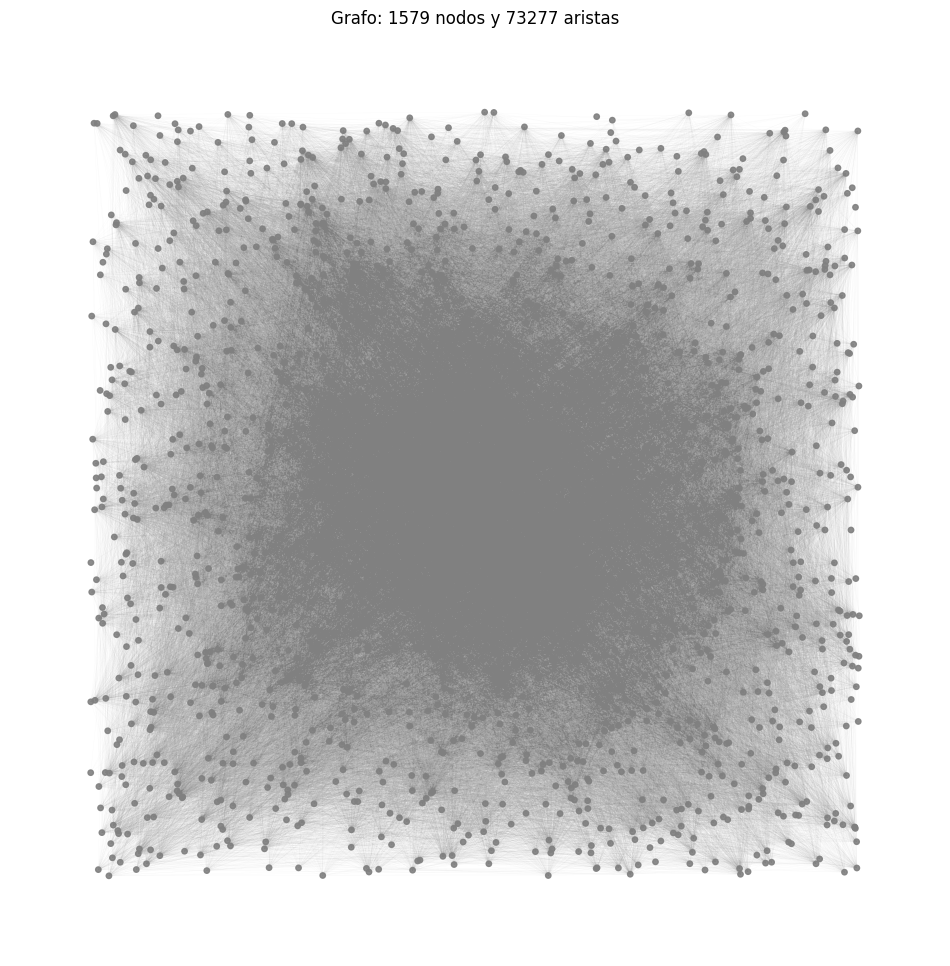

In [24]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def visualizar_grafo_matplotlib():
    print("Cargando datos...")
    df_nodes = pd.read_csv("datos_season9.csv")
    df_edges = pd.read_csv("aristas_grafo.csv")

    # 1. Crear el objeto grafo
    G = nx.Graph()

    # 2. Añadir nodos con sus atributos de color
    # Usamos un diccionario para mapear ID -> Color
    color_map = {}
    for _, row in df_nodes.iterrows():
        color = str(row['hexadecimal']).strip()
        if not color.startswith('#'):
            color = '#' + color
        color_map[row['id']] = color

    # 3. Añadir las aristas
    print("Añadiendo aristas...")
    edges = list(zip(df_edges['ID_1'], df_edges['ID_2']))
    G.add_edges_from(edges)

    # --- EL TRUCO PARA EVITAR EL VALUEERROR ---
    # Solo extraemos los colores de los nodos que REALMENTE están en el grafo
    # y en el orden correcto en el que G.nodes() los tiene.
    colores_finales = []
    for node in G.nodes():
        # Si el nodo existe en el grafo pero no estaba en el csv de nodos (raro pero pasa)
        # le ponemos un color gris por defecto.
        colores_finales.append(color_map.get(node, '#808080'))

    # 4. Configurar el dibujo
    plt.figure(figsize=(12, 12))
    plt.title(f"Grafo: {len(G.nodes())} nodos y {len(G.edges())} aristas")

    print("Calculando posiciones...")
    # random_layout es el más rápido para tantos nodos
    pos = nx.random_layout(G)

    print("Dibujando...")
    # Dibujamos aristas muy finas
    nx.draw_networkx_edges(G, pos, alpha=0.05, edge_color='gray', width=0.2)
    
    # Dibujamos nodos con la lista de colores validada
    nx.draw_networkx_nodes(
        G, 
        pos, 
        node_size=15, 
        node_color=colores_finales, # Ahora miden lo mismo (969)
        alpha=0.9
    )

    print("Listo. Mostrando ventana...")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    visualizar_grafo_matplotlib()

# Intento de Creacion desde Prompt

In [25]:
df_nodos = pd.read_csv('s9.csv')
df_nodoss9 = df_nodos.drop('Unnamed: 0', axis=1)
df_nodos = df_nodoss9.reset_index()
df_nodos

,index,id,title,family_id,brand,origin,season,color,hexadecimal,top_type,adventurous,weather,print,style,fit,application,Nivel
0,0,8b30be61-1658-4c01-8607-3493c3da358b,Viblue Jacket noos,c6b81db8-29ed-43d6-b14d-0fd913d7ce36,BRAND55,MAINSTREAM,9,blue_light,87CEFA,NaN,3,cold_season,smooth,street,tight,freetime,3
1,1,e35ab256-d1a0-4608-913a-012390cdd097,Dima Shirt basc,c59807ac-0362-4078-94b0-37ea3df6cdd0,BRAND89,MAINSTREAM,9,blue_light,87CEFA,shirt,1,cold_season,smooth,classic,tight,working_girl,2
2,2,79139595-80b1-4151-be8c-c2b94b8b318b,Amanda Short woven,9c5a3fee-dad0-444a-acb3-c059e2f3db20,BRAND132,NO_MAINSTREAM,9,brown_light,A57E62,NaN,2,warm,smooth,casual,straight,freetime,1
3,3,016c8e92-c49a-4619-95ef-2b4c8aaf338a,Viril Cardigan noos,141f32d6-a5af-49bf-b019-fd28354977f1,BRAND55,MAINSTREAM,9,brown_light,A57E62,cardigan,2,cold_season,smooth,boho,straight,freetime,2
4,4,8476b4d2-fab9-4451-88f8-c72af3a96cd0,Summ Top cerise,39792668-5cfd-42c2-8872-ad776e9bad70,BRAND15,WHOLE_SALE,9,yellow,FFFF00,tops,2,warm,floral,boho,straight,freetime,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1703,1703,bd6567d1-cee5-4f9e-b469-d30bb2870382,Buttons Skirt midi,2514d6c8-11e6-4692-87b4-dcc1cd18592c,BRAND60,WHOLE_SALE,9,khaki,666633,NaN,3,warm_season,smooth,boho,straight,freetime,1
1704,1704,bc28a3d9-fec5-4a17-856d-0e524b494d78,Cassie Bag nice,882ecdf8-325d-4826-a066-1b263e438f09,BRAND100,NO_MAINSTREAM,9,brown_light,A57E62,NaN,2,warm_season,horizontal_stripes,boho,NaN,freetime,3
1705,1705,993165a3-309e-4859-8e9a-c22b3902d686,Sparta Scarf sew,b263ba41-adab-4a83-a3e0-2766522f5aec,BRAND143,OWN_PRODUCTION,9,grey_blue,768597,NaN,2,warm_season,smooth,boho,NaN,freetime,3
1706,1706,b56d7276-1c0b-45f8-8c2f-34d3b3fee57f,Leeds Scarf closet,b263ba41-adab-4a83-a3e0-2766522f5aec,BRAND167,OWN_PRODUCTION,9,mint,c4ddce,NaN,2,warm_season,floral,boho,NaN,work,3


In [26]:
import pandas as pd
import networkx as nx


def crear_grafo():
    # 1. Cargar los datasets
    # Asumimos que los archivos están en el mismo directorio que el script
    try:
        # df_nodos = pd.read_csv('s9.csv')
        df_aristas = pd.read_csv('aristas_grafo.csv')
    except FileNotFoundError as e:
        print(f"Error: No se encontró el archivo. {e}")
        return

    # 2. Inicializar el grafo no dirigido
    G = nx.Graph()

    # 3. Añadir los nodos con sus atributos
    # Iteramos por cada fila del dataframe de nodos
    for _, fila in df_nodos.iterrows():
        # Usamos el 'id' como identificador único del nodo
        id_nodo = fila['index']
        # Creamos un diccionario con el resto de la información como atributos
        atributos = fila.drop('index').to_dict()
        G.add_node(id_nodo, **atributos)

    # 4. Añadir las aristas
    # Iteramos por el dataframe de aristas
    for _, fila in df_aristas.iterrows():
        u = fila['ID_1']
        v = fila['ID_2']
        w = fila['weight']
        G.add_edge(u, v, weight=w)

    # 5. Comprobaciones
    num_filas_nodos = len(df_nodos)
    num_nodos_grafo = G.number_of_nodes()
    
    num_filas_aristas = len(df_aristas)
    num_aristas_grafo = G.number_of_edges()

    print("--- Comprobaciones de Integridad ---")
    
    # Verificación de Nodos
    if num_filas_nodos == num_nodos_grafo:
        print(f"✅ Éxito: El número de nodos ({num_nodos_grafo}) coincide con las filas del dataset.")
    else:
        print(f"❌ Error: El número de nodos ({num_nodos_grafo}) NO coincide con las filas ({num_filas_nodos}).")
        # Nota: Esto puede pasar si hay IDs duplicados en el CSV de nodos.

    # Verificación de Aristas
    if num_filas_aristas == num_aristas_grafo:
        print(f"✅ Éxito: El número de aristas ({num_aristas_grafo}) coincide con las filas del dataset.")
    else:
        print(f"⚠️ Aviso: El número de aristas ({num_aristas_grafo}) es distinto a las filas ({num_filas_aristas}).")
        print("   (Esto puede ocurrir si existen conexiones duplicadas o bucles en el archivo de aristas)")

    return G

# Ejecutar la creación
grafo_final = crear_grafo()

# Ejemplo: Ver información del primer nodo (opcional)
if grafo_final and grafo_final.number_of_nodes() > 0:
    primer_nodo = list(grafo_final.nodes)[0]
    print(f"\nAtributos del nodo {primer_nodo}:")
    print(grafo_final.nodes[primer_nodo])

--- Comprobaciones de Integridad ---
✅ Éxito: El número de nodos (1708) coincide con las filas del dataset.
✅ Éxito: El número de aristas (73277) coincide con las filas del dataset.

Atributos del nodo 0:
{'id': '8b30be61-1658-4c01-8607-3493c3da358b', 'title': 'Viblue Jacket noos', 'family_id': 'c6b81db8-29ed-43d6-b14d-0fd913d7ce36', 'brand': 'BRAND55', 'origin': 'MAINSTREAM', 'season': 9, 'color': 'blue_light', 'hexadecimal': '87CEFA', 'top_type': nan, 'adventurous': 3, 'weather': 'cold_season', 'print': 'smooth', 'style': 'street', 'fit': 'tight', 'application': 'freetime', 'Nivel': 3}


In [27]:
import pandas as pd
import networkx as nx

# Cargar datos
# df_nodos = pd.read_csv('s9.csv')
df_aristas = pd.read_csv('aristas_grafo.csv')

print("--- DIAGNÓSTICO DE DATOS ---")

# 1. Analizar IDs duplicados
duplicados_nodos = df_nodos[df_nodos.duplicated('index', keep=False)]
print(f"Filas con IDs duplicados: {len(duplicados_nodos)}")
if not duplicados_nodos.empty:
    print("Ejemplo de IDs repetidos:")
    print(duplicados_nodos['id'].head())

# 2. Analizar Aristas duplicadas (Normalizando A-B y B-A)
# Ordenamos los IDs para que (A, B) y (B, A) se vean iguales
edges_temp = df_aristas[['ID_1', 'ID_2']].copy()
edges_temp[['ID_1', 'ID_2']] = pd.DataFrame(
    [sorted(x) for x in edges_temp.values], 
    index=edges_temp.index
)

aristas_unicas = edges_temp.duplicated().sum()
print(f"\nAristas que son duplicadas o inversas: {aristas_unicas}")

# 3. Crear el Grafo Limpio
G = nx.Graph()

# Añadir nodos eliminando duplicados en el DataFrame primero
df_nodos_clean = df_nodos.drop_duplicates(subset='index')
for _, fila in df_nodos_clean.iterrows():
    G.add_node(fila['index'], **fila.drop('index').to_dict())

# Añadir aristas
for _, fila in df_aristas.iterrows():
    G.add_edge(fila['ID_1'], fila['ID_2'], weight=fila['weight'])

print("\n--- NUEVA COMPROBACIÓN ---")
print(f"Nodos finales: {G.number_of_nodes()} (Deberían ser {len(df_nodos_clean)})")
print(f"Aristas finales: {G.number_of_edges()}")

--- DIAGNÓSTICO DE DATOS ---
Filas con IDs duplicados: 0

Aristas que son duplicadas o inversas: 0

--- NUEVA COMPROBACIÓN ---
Nodos finales: 1708 (Deberían ser 1708)
Aristas finales: 73277


GPT

In [28]:
import pandas as pd
import networkx as nx

# -----------------------------
# 1. Cargar los datos
# -----------------------------
datos_nodos = pd.read_csv("s9.csv")
datos_aristas = pd.read_csv("aristas_grafo.csv")

# -----------------------------
# 2. Crear grafo no dirigido
# -----------------------------
G = nx.Graph()

# -----------------------------
# 3. Añadir nodos con atributos
# Cada fila del dataset es un nodo
# -----------------------------
for _, fila in datos_nodos.iterrows():
    nodo_id = fila["id"]
    
    # Convertimos la fila a diccionario para usarla como atributos del nodo
    atributos = fila.to_dict()
    
    G.add_node(nodo_id, **atributos)

# -----------------------------
# 4. Añadir aristas
# -----------------------------
for _, fila in datos_aristas.iterrows():
    id_1 = fila["ID_1"]
    id_2 = fila["ID_2"]
    weight = fila["weight"]
    
    G.add_edge(id_1, id_2, weight=weight)

# -----------------------------
# 5. Comprobaciones
# -----------------------------
num_filas_dataset = len(datos_nodos)
num_nodos_grafo = G.number_of_nodes()

num_filas_aristas = len(datos_aristas)
num_aristas_grafo = G.number_of_edges()

print("---- COMPROBACIONES ----")
print(f"Filas en datos_para_grafo.csv: {num_filas_dataset}")
print(f"Nodos en el grafo:             {num_nodos_grafo}")

print(f"Filas en aristas_grafo.csv:    {num_filas_aristas}")
print(f"Aristas en el grafo:           {num_aristas_grafo}")

# Validaciones estrictas
assert num_filas_dataset == num_nodos_grafo, \
    "❌ El número de nodos no coincide con el número de filas del dataset"

assert num_filas_aristas == num_aristas_grafo, \
    "❌ El número de aristas no coincide con el número de filas de aristas_grafo.csv"

print("✅ Grafo creado correctamente")


---- COMPROBACIONES ----
Filas en datos_para_grafo.csv: 1708
Nodos en el grafo:             2548
Filas en aristas_grafo.csv:    73277
Aristas en el grafo:           73277


AssertionError: ❌ El número de nodos no coincide con el número de filas del dataset

# Intento 3 - Definitivo?

In [ ]:
import pandas as pd
season9 = pd.read_csv('s9.csv')

season9

,Unnamed: 0,id,title,family_id,brand,origin,season,color,hexadecimal,top_type,adventurous,weather,print,style,fit,application,Nivel
0,0,8b30be61-1658-4c01-8607-3493c3da358b,Viblue Jacket noos,c6b81db8-29ed-43d6-b14d-0fd913d7ce36,BRAND55,MAINSTREAM,9,blue_light,87CEFA,NaN,3,cold_season,smooth,street,tight,freetime,3
1,1,e35ab256-d1a0-4608-913a-012390cdd097,Dima Shirt basc,c59807ac-0362-4078-94b0-37ea3df6cdd0,BRAND89,MAINSTREAM,9,blue_light,87CEFA,shirt,1,cold_season,smooth,classic,tight,working_girl,2
2,2,79139595-80b1-4151-be8c-c2b94b8b318b,Amanda Short woven,9c5a3fee-dad0-444a-acb3-c059e2f3db20,BRAND132,NO_MAINSTREAM,9,brown_light,A57E62,NaN,2,warm,smooth,casual,straight,freetime,1
3,3,016c8e92-c49a-4619-95ef-2b4c8aaf338a,Viril Cardigan noos,141f32d6-a5af-49bf-b019-fd28354977f1,BRAND55,MAINSTREAM,9,brown_light,A57E62,cardigan,2,cold_season,smooth,boho,straight,freetime,2
4,4,8476b4d2-fab9-4451-88f8-c72af3a96cd0,Summ Top cerise,39792668-5cfd-42c2-8872-ad776e9bad70,BRAND15,WHOLE_SALE,9,yellow,FFFF00,tops,2,warm,floral,boho,straight,freetime,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1703,1703,bd6567d1-cee5-4f9e-b469-d30bb2870382,Buttons Skirt midi,2514d6c8-11e6-4692-87b4-dcc1cd18592c,BRAND60,WHOLE_SALE,9,khaki,666633,NaN,3,warm_season,smooth,boho,straight,freetime,1
1704,1704,bc28a3d9-fec5-4a17-856d-0e524b494d78,Cassie Bag nice,882ecdf8-325d-4826-a066-1b263e438f09,BRAND100,NO_MAINSTREAM,9,brown_light,A57E62,NaN,2,warm_season,horizontal_stripes,boho,NaN,freetime,3
1705,1705,993165a3-309e-4859-8e9a-c22b3902d686,Sparta Scarf sew,b263ba41-adab-4a83-a3e0-2766522f5aec,BRAND143,OWN_PRODUCTION,9,grey_blue,768597,NaN,2,warm_season,smooth,boho,NaN,freetime,3
1706,1706,b56d7276-1c0b-45f8-8c2f-34d3b3fee57f,Leeds Scarf closet,b263ba41-adab-4a83-a3e0-2766522f5aec,BRAND167,OWN_PRODUCTION,9,mint,c4ddce,NaN,2,warm_season,floral,boho,NaN,work,3


In [ ]:
aristas = pd.read_csv('aristas_grafo.csv')
aristas

,ID_1,ID_2,Nombre_1,Nombre_2,weight
0,c7a078b8-04b6-4227-b92f-ad6754e3a039,b8616761-dbbf-4fea-9756-149dd3cfe53a,Onltaho Jacket ny,Onlglamour Sweater knit,1
1,c7a078b8-04b6-4227-b92f-ad6754e3a039,8780d58a-9535-4a6e-998c-696b4f765111,Onltaho Jacket ny,Femme Sweater mohair,1
2,c7a078b8-04b6-4227-b92f-ad6754e3a039,69786685-c431-4511-9574-a168da76601b,Onltaho Jacket ny,Caro Jeans gj,1
3,c7a078b8-04b6-4227-b92f-ad6754e3a039,f14f4932-9a0e-4a3a-998d-26b0f3454c4d,Onltaho Jacket ny,Onlarya Sweater nc,1
4,c7a078b8-04b6-4227-b92f-ad6754e3a039,f14f4932-9a0e-4a3a-998d-26b0f3454c4d,Onltaho Jacket ny,Onlarya Sweater nc,1
...,...,...,...,...,...
138688,1ff9def6-fae9-4a66-9de6-49ab7f9da10f,45a100ff-3418-41ee-9875-017c6b251346,Bodiam Scarf closet,Almond Shirt print,1
138689,8da9d2d5-7531-4849-8623-d177b7c12261,45a100ff-3418-41ee-9875-017c6b251346,Warwick Scarf closet,Almond Shirt print,1
138690,b2800db0-2ceb-487c-88de-b78a0ef32422,45a100ff-3418-41ee-9875-017c6b251346,Berta Scarf closet,Almond Shirt print,1
138691,726fc560-8397-47fb-ac9f-41d1be50f222,45a100ff-3418-41ee-9875-017c6b251346,Brina Scarf closet,Almond Shirt print,1
